In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../")

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torchsummary import summary

from data.input_transforms import InputTransform
from data.cifar import CIFAR
from data.stl import STL, LABEL_MAP
from data.dataloader import get_dataloader
from models.optimizer import optimizer, scheduler
from networks.twolayernet import TwolayerNet
from networks.convnet import ConvNet
from utils.viz import plot_multiple_quantities_by_time, show_many_images
from main import train, evaluate

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


### Load dataset

In [4]:
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


### Load model

In [5]:
# test checkpoint loading
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=True,
)

#### Visualize samples from the dataset

In [6]:
valid_labels = valid_dataset.targets
classes = np.unique(valid_labels)

indices = []
sampled = []
for i, l in enumerate(valid_labels):
    if l not in sampled:
        indices.extend(np.random.choice(np.where(valid_labels == l)[0], 2))
        sampled.append(l)

In [7]:
indices, sampled

([335, 408, 451, 52, 197, 479, 20, 180, 89, 86], [2, 4, 1, 6, 9])

In [8]:
images = []
labels = []

for i in indices:
    image = valid_dataset.data[i]
    label = valid_dataset.targets[i]
    images.append(image)
    labels.append(label)

In [9]:
valid_labels[indices]

array([2, 2, 4, 4, 1, 1, 6, 6, 9, 9])

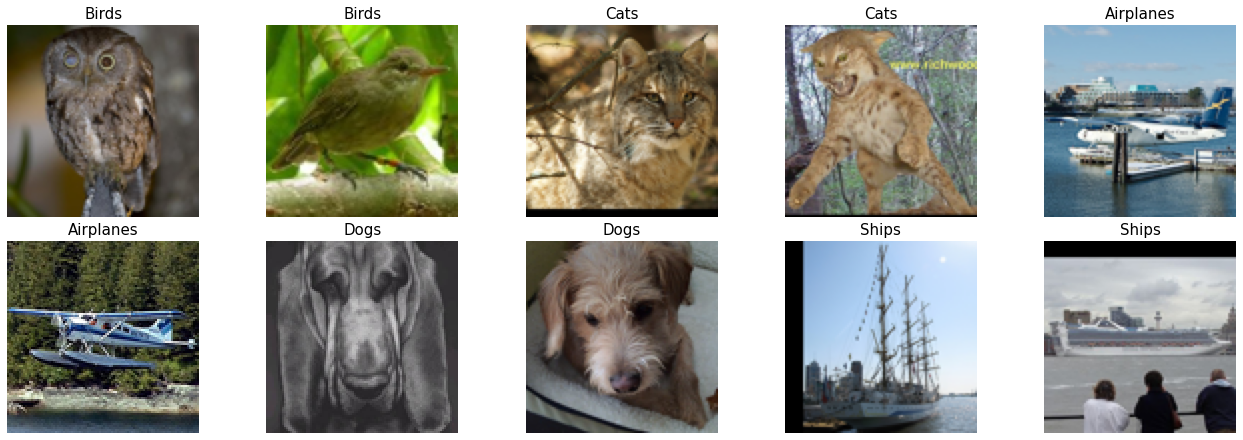

In [10]:
show_many_images(
    images, grid=(2, 5),
    subtitles=[LABEL_MAP[x].capitalize() for x in labels],
    save=True, save_path="../results/stl_samples.png",
)

### Visualize features without finetuning

In [11]:
net = net.eval()

In [12]:
val_features = []
valid_labels = []

iterator = tqdm(valid_loader, f"Extracting features", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
with torch.no_grad():
    for i, batch in enumerate(iterator):
        images, targets = batch
        output = net(images)
        val_features.append(output.numpy())
        valid_labels.append(targets.numpy())

Extracting features: 100%|██████████████████████████████| 4/4 [00:00<00:00, 53.22it/s]                                                     


In [13]:
valid_features = np.vstack(val_features)
valid_labels = np.concatenate(valid_labels)

In [14]:
valid_features.shape, valid_labels.shape

((500, 400), (500,))

In [15]:
X = valid_features
y = valid_labels

In [16]:
def visualize_features(
        X, y,
        title="Sample features",
        seed=0,
        save=False,
        save_path="../results/sample.png",
        show=True,
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    Z = tsne.fit_transform(X)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "label"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["label"] = [LABEL_MAP[a].capitalize() for a in y]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=df,
        x="Z1", y="Z2", hue="label", palette="Set2", legend=True, ax=ax, s=100,
    )
    ax.set_title(title, fontsize=17)
    
    plt.legend(fontsize=14)

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    
    if save:
        plt.show()

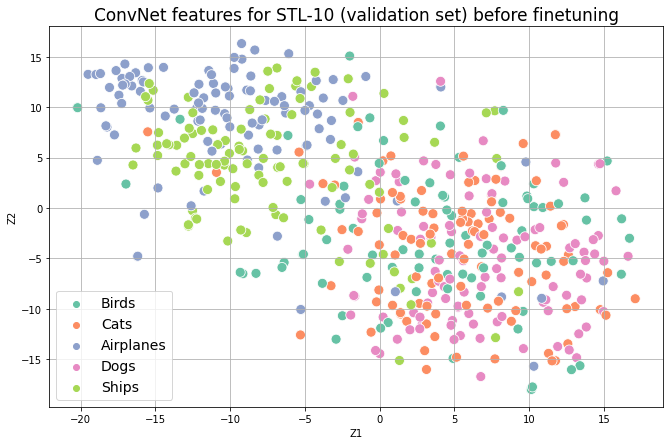

In [17]:
visualize_features(
    X, y,
    title="ConvNet features for STL-10 (validation set) before finetuning",
    save_path="../results/convnet_features_before_finetuning.png", save=True,
)

### Evaluate pre-trained model on new validation set without finetuning

In [18]:
valid_transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]
valid_transform = InputTransform(valid_transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=True)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


In [19]:
# test checkpoint loading
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=False,
)
net = net.eval()

In [20]:
evaluate(net, valid_loader, nn.CrossEntropyLoss(), 1, 1, mode="valid")

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 63.32it/s]                                                   

VALID 	: Summary: Loss: 1.7306 Accuracy: 0.1620


(1.7305774986743927, 0.162)

### Train the network

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)
:::: Loaded dataset from ../datasets/STL-10/: X ((2000, 96, 96, 3)) y (2000)
:::: Loaded dataset from ../datasets/STL-10/: X ((4000, 96, 96, 3)) y (4000)


Evaluate: Epoch [1/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.54it/s]                                                  


VALID 	: Summary: Loss: 1.2821 Accuracy: 0.4280
TRAIN 	: Summary: Loss: 1.7430 Accuracy: 0.3000


Evaluate: Epoch [2/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.15it/s]                                                  


VALID 	: Summary: Loss: 1.1303 Accuracy: 0.5000
TRAIN 	: Summary: Loss: 1.2377 Accuracy: 0.4620


Evaluate: Epoch [3/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.98it/s]                                                  


VALID 	: Summary: Loss: 1.0071 Accuracy: 0.5680
TRAIN 	: Summary: Loss: 1.1084 Accuracy: 0.5120


Evaluate: Epoch [4/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.43it/s]                                                  


VALID 	: Summary: Loss: 0.9119 Accuracy: 0.6280
TRAIN 	: Summary: Loss: 0.9879 Accuracy: 0.5480


Evaluate: Epoch [5/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.49it/s]                                                  


VALID 	: Summary: Loss: 0.7853 Accuracy: 0.6720
TRAIN 	: Summary: Loss: 0.9082 Accuracy: 0.6240


Evaluate: Epoch [6/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.17it/s]                                                  


VALID 	: Summary: Loss: 0.7023 Accuracy: 0.7220
TRAIN 	: Summary: Loss: 0.7927 Accuracy: 0.6820


Evaluate: Epoch [7/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.73it/s]                                                  


VALID 	: Summary: Loss: 0.5594 Accuracy: 0.7960
TRAIN 	: Summary: Loss: 0.6827 Accuracy: 0.7220


Evaluate: Epoch [8/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.93it/s]                                                  


VALID 	: Summary: Loss: 0.4422 Accuracy: 0.8480
TRAIN 	: Summary: Loss: 0.5442 Accuracy: 0.7960


Evaluate: Epoch [9/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.13it/s]                                                  


VALID 	: Summary: Loss: 0.3457 Accuracy: 0.8860
TRAIN 	: Summary: Loss: 0.4272 Accuracy: 0.8520


Evaluate: Epoch [10/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.66it/s]                                                 


VALID 	: Summary: Loss: 0.2734 Accuracy: 0.9140
TRAIN 	: Summary: Loss: 0.3140 Accuracy: 0.8920


Evaluate: Epoch [11/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.75it/s]                                                 


VALID 	: Summary: Loss: 0.1528 Accuracy: 0.9640
TRAIN 	: Summary: Loss: 0.2391 Accuracy: 0.9320


Evaluate: Epoch [12/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.72it/s]                                                 


VALID 	: Summary: Loss: 0.0975 Accuracy: 0.9740
TRAIN 	: Summary: Loss: 0.1547 Accuracy: 0.9580


Evaluate: Epoch [13/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 83.30it/s]                                                 


VALID 	: Summary: Loss: 0.0812 Accuracy: 0.9760
TRAIN 	: Summary: Loss: 0.1078 Accuracy: 0.9700


Evaluate: Epoch [14/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.09it/s]                                                 


VALID 	: Summary: Loss: 0.0301 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0779 Accuracy: 0.9740


Evaluate: Epoch [15/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.75it/s]                                                 


VALID 	: Summary: Loss: 0.0293 Accuracy: 0.9940
TRAIN 	: Summary: Loss: 0.0439 Accuracy: 0.9900


Evaluate: Epoch [16/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.65it/s]                                                 


VALID 	: Summary: Loss: 0.0178 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0241 Accuracy: 0.9960


Evaluate: Epoch [17/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.70it/s]                                                 


VALID 	: Summary: Loss: 0.0150 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0218 Accuracy: 0.9960


Evaluate: Epoch [18/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.33it/s]                                                 


VALID 	: Summary: Loss: 0.1028 Accuracy: 0.9640
TRAIN 	: Summary: Loss: 0.0201 Accuracy: 0.9940


Evaluate: Epoch [19/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.79it/s]                                                 


VALID 	: Summary: Loss: 0.0129 Accuracy: 1.0000
TRAIN 	: Summary: Loss: 0.0719 Accuracy: 0.9820


Evaluate: Epoch [20/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.37it/s]                                                 


VALID 	: Summary: Loss: 0.0303 Accuracy: 0.9960
TRAIN 	: Summary: Loss: 0.0421 Accuracy: 0.9840


Evaluate: Epoch [21/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.21it/s]                                                 


VALID 	: Summary: Loss: 0.0588 Accuracy: 0.9800
TRAIN 	: Summary: Loss: 0.0345 Accuracy: 0.9940


Evaluate: Epoch [22/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.86it/s]                                                 


VALID 	: Summary: Loss: 0.0769 Accuracy: 0.9720
TRAIN 	: Summary: Loss: 0.0498 Accuracy: 0.9840


Evaluate: Epoch [23/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.01it/s]                                                 


VALID 	: Summary: Loss: 0.0906 Accuracy: 0.9720
TRAIN 	: Summary: Loss: 0.0727 Accuracy: 0.9740


Evaluate: Epoch [24/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.31it/s]                                                 


VALID 	: Summary: Loss: 0.0182 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0704 Accuracy: 0.9800


Evaluate: Epoch [25/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 85.45it/s]                                                 


VALID 	: Summary: Loss: 0.0247 Accuracy: 0.9960
TRAIN 	: Summary: Loss: 0.0683 Accuracy: 0.9780


Evaluate: Epoch [26/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.57it/s]                                                 


VALID 	: Summary: Loss: 0.0315 Accuracy: 0.9920
TRAIN 	: Summary: Loss: 0.0809 Accuracy: 0.9760


Evaluate: Epoch [27/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.99it/s]                                                 


VALID 	: Summary: Loss: 0.0391 Accuracy: 0.9880
TRAIN 	: Summary: Loss: 0.0543 Accuracy: 0.9820


Evaluate: Epoch [28/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.61it/s]                                                 


VALID 	: Summary: Loss: 0.0472 Accuracy: 0.9860
TRAIN 	: Summary: Loss: 0.0730 Accuracy: 0.9740


Evaluate: Epoch [29/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.34it/s]                                                 


VALID 	: Summary: Loss: 0.0423 Accuracy: 0.9860
TRAIN 	: Summary: Loss: 0.0446 Accuracy: 0.9820


Evaluate: Epoch [30/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 79.35it/s]                                                 


VALID 	: Summary: Loss: 0.0314 Accuracy: 0.9920
TRAIN 	: Summary: Loss: 0.0540 Accuracy: 0.9840


Evaluate: Epoch [31/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.21it/s]                                                 


VALID 	: Summary: Loss: 0.0190 Accuracy: 0.9960
TRAIN 	: Summary: Loss: 0.0362 Accuracy: 0.9860


Evaluate: Epoch [32/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.92it/s]                                                 


VALID 	: Summary: Loss: 0.0080 Accuracy: 1.0000
TRAIN 	: Summary: Loss: 0.0313 Accuracy: 0.9900


Evaluate: Epoch [33/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.72it/s]                                                 


VALID 	: Summary: Loss: 0.0076 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0234 Accuracy: 0.9960


Evaluate: Epoch [34/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.80it/s]                                                 


VALID 	: Summary: Loss: 0.0185 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0105 Accuracy: 0.9960


Evaluate: Epoch [35/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.12it/s]                                                 


VALID 	: Summary: Loss: 0.0079 Accuracy: 1.0000
TRAIN 	: Summary: Loss: 0.0179 Accuracy: 0.9980


Evaluate: Epoch [36/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.67it/s]                                                 


VALID 	: Summary: Loss: 0.0046 Accuracy: 1.0000
TRAIN 	: Summary: Loss: 0.0150 Accuracy: 0.9940


Evaluate: Epoch [37/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 80.14it/s]                                                 


VALID 	: Summary: Loss: 0.0021 Accuracy: 1.0000
TRAIN 	: Summary: Loss: 0.0111 Accuracy: 0.9980


Evaluate: Epoch [38/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 81.26it/s]                                                 


VALID 	: Summary: Loss: 0.0054 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0049 Accuracy: 0.9980


Evaluate: Epoch [39/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 82.37it/s]                                                 


VALID 	: Summary: Loss: 0.0045 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0049 Accuracy: 0.9980


Evaluate: Epoch [40/40]: 100%|██████████████████████████████| 4/4 [00:00<00:00, 84.01it/s]                                                 


VALID 	: Summary: Loss: 0.0063 Accuracy: 0.9980
TRAIN 	: Summary: Loss: 0.0063 Accuracy: 0.9980


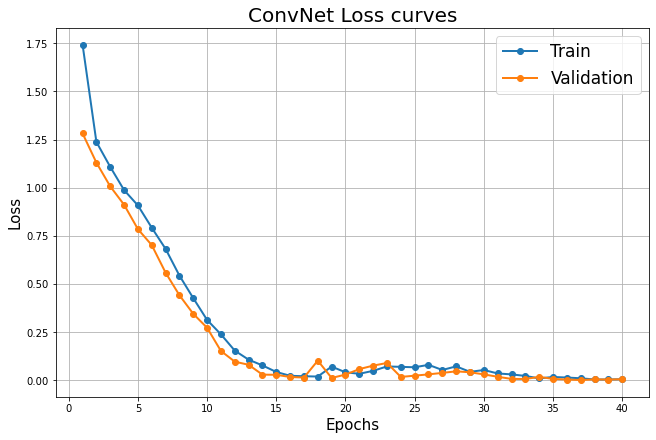

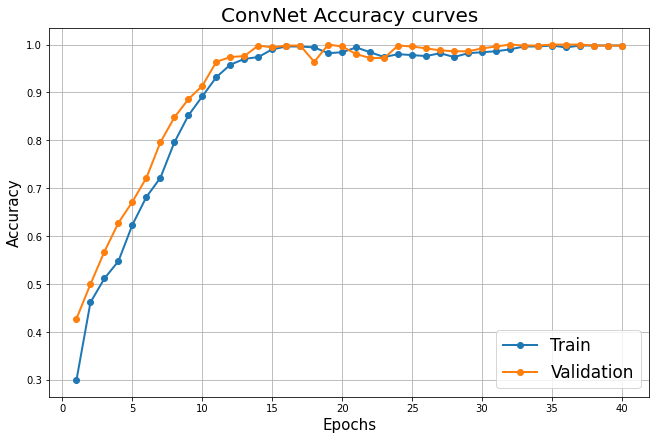

In [21]:
# define network
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_best_hparams.pt",
    return_features=False,
)

# define transforms
transforms = [
    {
        "name": "ToTensor",
        "args": {},
    },
    {
        "name": "Resize",
        "args": {"size": 32},
    },
    {
        "name": "Normalize",
        "args": {"mean": (0.5, 0.5, 0.5), "std": (0.5, 0.5, 0.5)},
    },
]

# define the datasets
valid_transform = InputTransform(transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=True)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

train_transform = InputTransform(transforms)
train_dataset = STL(root="../datasets/STL-10/", mode="train", transform=train_transform, encode_labels=True)
train_loader = get_dataloader(valid_dataset, train=True, batch_size=128, num_workers=0)

test_transform = InputTransform(transforms)
test_dataset = STL(root="../datasets/STL-10/", mode="test", transform=test_transform, encode_labels=True)
test_loader = get_dataloader(test_dataset, train=False, batch_size=128, num_workers=0)

# define the optimizer and scheduler

num_epochs = 40
batch_size = 128
opt_args = {"name": "Adam", "lr": 1e-2}

sch_args = None
# sch_args = {"name": "MultiStepLR", "milestones": [50], "gamma": 0.1}

opt = optimizer(model_params=net.parameters(), **opt_args)
sch = None
if sch_args is not None:
    sch = scheduler(opt=opt, **sch_args)
    
# define the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs, train_losses, train_metrics, valid_losses, valid_metrics = train(
    net, loss_fn, train_loader, valid_loader, num_epochs=num_epochs, opt=opt, sch=sch,
)

arch = type(net).__name__

# plot training curves
plot_multiple_quantities_by_time(
    quantities=[train_losses["loss"], valid_losses["loss"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Loss curves",
    show=True,
    save=True,
    save_path="../results/cnn_finetuning_loss_plot_default.png",
    ylabel="Loss",
)
plot_multiple_quantities_by_time(
    quantities=[train_metrics["accuracy"], valid_metrics["accuracy"]],
    time=epochs,
    labels=["Train", "Validation"],
    title=f"{arch} Accuracy curves",
    show=True,
    save=False,
    save_path="../results/cnn_accu_plot_best.png",
    ylabel="Accuracy",
)

In [22]:
torch.save(net, "../checkpoints/cnn_finetuned_default_stl.pt")

### Evaluate on test set

In [23]:
evaluate(net, test_loader, nn.CrossEntropyLoss(), 1, 1, mode="test")

Evaluate: Epoch [1/1]: 100%|██████████████████████████████| 32/32 [00:00<00:00, 78.07it/s]                                                 

TEST 	: Summary: Loss: 3.7574 Accuracy: 0.5367


(3.7573539838194847, 0.53675)

### Visualize features after finetuning

In [24]:
# define the datasets
valid_transform = InputTransform(transforms)
valid_dataset = STL(root="../datasets/STL-10/", mode="valid", transform=valid_transform, encode_labels=False)
valid_loader = get_dataloader(valid_dataset, train=False, batch_size=128, num_workers=0)

:::: Loaded dataset from ../datasets/STL-10/: X ((500, 96, 96, 3)) y (500)


In [25]:
net = ConvNet(
    in_channels=3,
    num_classes=5,
    ckpt_path="../checkpoints/cnn_finetuned_default_stl.pt",
    return_features=True,
    layer_to_ignore=None,
)
net = net.eval()

In [26]:
val_features = []
valid_labels = []

iterator = tqdm(valid_loader, f"Extracting features", bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')
with torch.no_grad():
    for i, batch in enumerate(iterator):
        images, targets = batch
        output = net(images)
        val_features.append(output.numpy())
        valid_labels.append(targets.numpy())

Extracting features: 100%|██████████████████████████████| 4/4 [00:00<00:00, 65.89it/s]                                                     


In [27]:
valid_features = np.vstack(val_features)
valid_labels = np.concatenate(valid_labels)

In [28]:
valid_features.shape, valid_labels.shape

((500, 400), (500,))

In [29]:
X = valid_features
y = valid_labels

In [30]:
def visualize_features(
        X, y,
        title="Sample features",
        seed=0,
        save=False,
        save_path="../results/sample.png",
        show=True,
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    Z = tsne.fit_transform(X)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "label"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["label"] = [LABEL_MAP[a].capitalize() for a in y]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=df,
        x="Z1", y="Z2", hue="label", palette="Set2", legend=True, ax=ax, s=100,
    )
    ax.set_title(title, fontsize=17)
    
    plt.legend(fontsize=14)

    if save:
        plt.savefig(save_path, bbox_inches="tight")
    
    if save:
        plt.show()

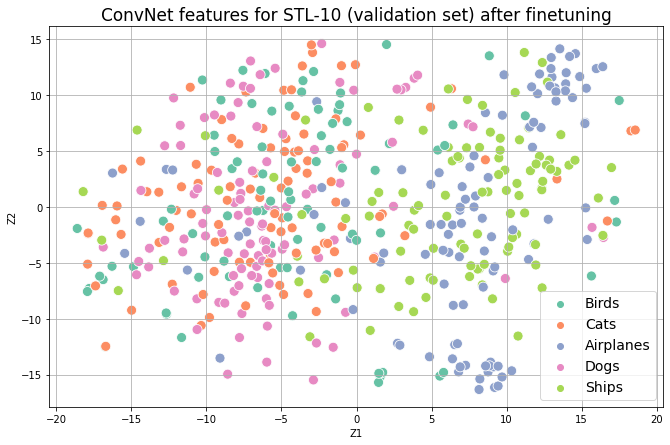

In [31]:
visualize_features(
    X, y,
    title="ConvNet features for STL-10 (validation set) after finetuning",
    save_path="../results/convnet_features_after_finetuning.png", save=True,
)